In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]
len(words)
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []
    context = [0] * block_size
    for w in words:

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(18)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182320, 3]) torch.Size([182320])
torch.Size([22953, 3]) torch.Size([22953])
torch.Size([22873, 3]) torch.Size([22873])


In [14]:
#MLP
n_embd = 20
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3)/(n_embd * block_size)**0.5 # 0.2
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

18567


In [15]:
# Training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    factor = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)
    hpreact = bngain * factor + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = 0.1 if i < 100000 else 0.01
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3083
  10000/ 200000: 2.2623
  20000/ 200000: 2.1999
  30000/ 200000: 2.7874
  40000/ 200000: 2.5571
  50000/ 200000: 2.6784
  60000/ 200000: 2.1481
  70000/ 200000: 2.1223
  80000/ 200000: 2.2458
  90000/ 200000: 2.3655
 100000/ 200000: 1.8547
 110000/ 200000: 2.3311
 120000/ 200000: 2.1830
 130000/ 200000: 2.1242
 140000/ 200000: 2.3588
 150000/ 200000: 2.0704
 160000/ 200000: 2.1131
 170000/ 200000: 2.7067
 180000/ 200000: 2.2561
 190000/ 200000: 2.0655


(array([1299.,  316.,  184.,  149.,  112.,  106.,   78.,   66.,   90.,
          73.,   62.,   57.,   62.,   49.,   49.,   56.,   63.,   47.,
          49.,   36.,   44.,   48.,   43.,   46.,   52.,   44.,   42.,
          36.,   38.,   51.,   46.,   59.,   58.,   49.,   64.,   64.,
          53.,   67.,   62.,   60.,   74.,   89.,   80.,   95.,   98.,
         121.,  148.,  171.,  275., 1220.]),
 array([-9.99999881e-01, -9.59999889e-01, -9.19999897e-01, -8.79999906e-01,
        -8.39999914e-01, -7.99999923e-01, -7.59999931e-01, -7.19999939e-01,
        -6.79999948e-01, -6.39999956e-01, -5.99999964e-01, -5.59999973e-01,
        -5.19999981e-01, -4.79999989e-01, -4.39999998e-01, -4.00000006e-01,
        -3.60000014e-01, -3.20000023e-01, -2.80000031e-01, -2.40000039e-01,
        -2.00000048e-01, -1.60000056e-01, -1.20000064e-01, -8.00000727e-02,
        -4.00000811e-02, -8.94069672e-08,  3.99999022e-02,  7.99998939e-02,
         1.19999886e-01,  1.59999877e-01,  1.99999869e-01,  2.399998

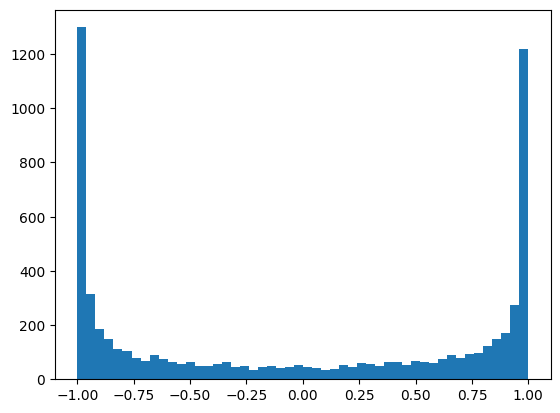

In [6]:
plt.hist(h.view(-1).tolist(), 50)

tensor(0.0162) tensor(1.0014)
tensor(1.9272e-05) tensor(0.9514)


(array([6.91391128e-05, 6.91391128e-05, 1.38278226e-04, 2.30463709e-04,
        4.37881048e-04, 7.83576612e-04, 1.33668952e-03, 2.41986895e-03,
        3.80265121e-03, 6.61430846e-03, 1.12696754e-02, 1.76765665e-02,
        2.71947177e-02, 4.15065141e-02, 6.16490423e-02, 9.01343568e-02,
        1.36296238e-01, 1.84854941e-01, 2.47310607e-01, 3.09835411e-01,
        3.72867236e-01, 4.21794681e-01, 4.45578536e-01, 4.43688734e-01,
        4.08727389e-01, 3.50581395e-01, 2.83147713e-01, 2.22812314e-01,
        1.66901818e-01, 1.16084570e-01, 8.27595181e-02, 5.50577802e-02,
        3.62058488e-02, 2.31155101e-02, 1.47035847e-02, 8.98808467e-03,
        5.57722177e-03, 2.83470363e-03, 1.79761693e-03, 1.10622581e-03,
        6.22252016e-04, 2.76556451e-04, 2.07417339e-04, 1.15231855e-04,
        4.60927419e-05, 0.00000000e+00, 0.00000000e+00, 2.30463709e-05,
        0.00000000e+00, 2.30463709e-05]),
 array([-4.95100689, -4.73405299, -4.51709909, -4.3001452 , -4.0831913 ,
        -3.8662374 , 

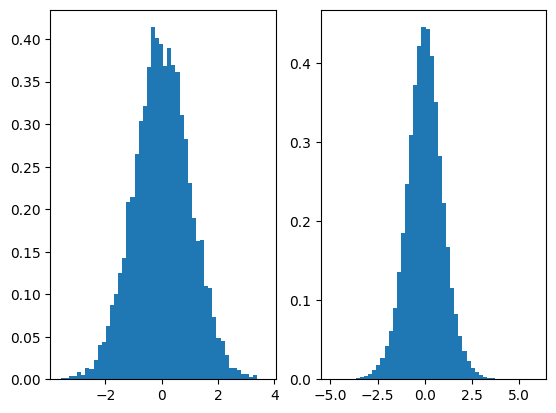

In [10]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure()
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    factor = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)
    hpreact = bngain * factor + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.1091666221618652
dev 2.148383617401123
